### Calculating intensity in an inclined direction $\cos\theta \neq 1$ 

For this first part we are going to use our good old FALC model and calculate intensity in direction other than $\mu = 1$. This is also an essential part of scattering problems! 

### We will assume that we are dealing with continuum everywhere!

In [51]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
matplotlib.rcParams.update({
    "text.usetex": True,
    "font.size" : 16,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})


In [52]:
# Let's load the data:
atmos = np.loadtxt("falc_71.dat",unpack=True,skiprows=1)
atmos.shape

(12, 71)

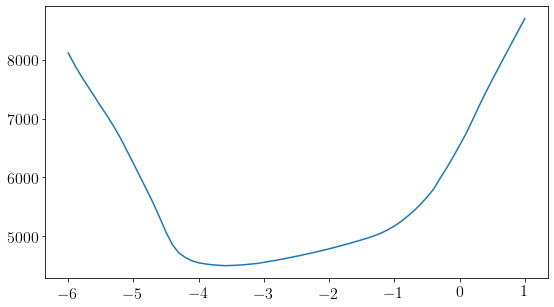

In [53]:
# 0th parameter - log optical depth in continuum (lambda = 500 nm)
# 2nd parameter - Temperature

plt.figure(figsize=[9,5])
plt.plot(atmos[0],atmos[2])

In [76]:
llambda = 500E-9 # in nm
k = 1.38E-23 # Boltzmann constant 
c = 3E8 # speed of light
h_p = 6.626E-34

T = np.copy(atmos[2])
logtau = np.copy(atmos[0])
tau = 10.** logtau

# We will separate now Planck function and the source function:
B = 2*h_p*c**2.0 / llambda**5.0  / (np.exp(h_p*c/(llambda*k*T))-1)
S = np.copy(B)



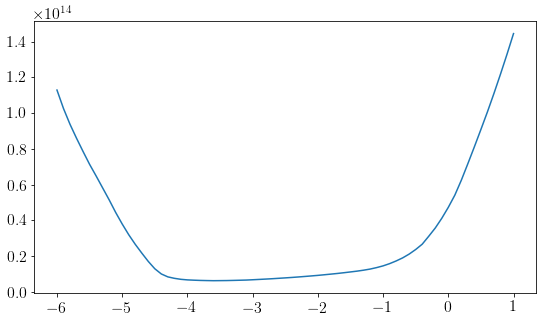

In [77]:
plt.figure(figsize=[9,5])
plt.plot(logtau,S)

#### We want to use a very simple formal solution:

### $$I = I_{inc} e^{-\Delta \tau} + S(1-e^{-\Delta \tau}) $$

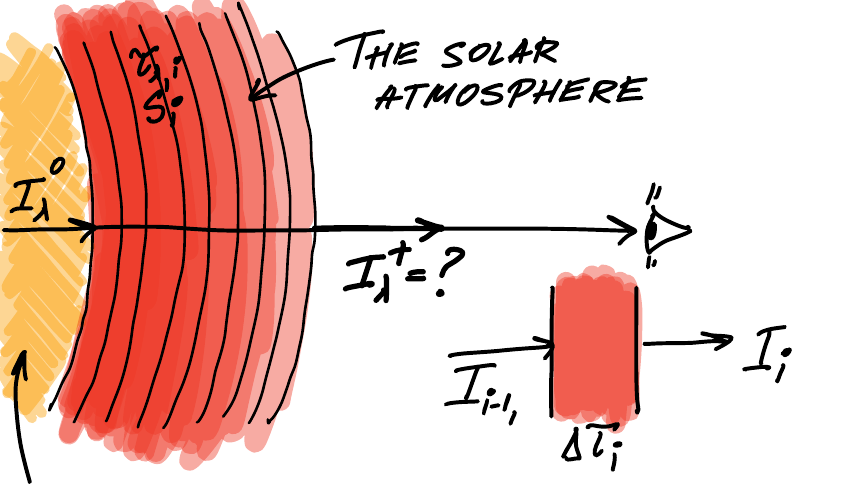

In [78]:
# Let's define a function that is doing that:

def synthesis_whole(S,tau):
    
    ND = len(S)
    intensity = np.zeros(ND)
    
    # At the bottom, intensity is equal to the source function (similar to Blackbody)
    intensity[ND-1] = S[ND-1]
    
    for d in range(ND-2,-1,-1):
        # optical thickness of the layer:
        delta_tau = tau[d+1] - tau[d]
        # Mean source function:
        S_mean = (S[d+1] + S[d])*0.5
        
        intensity[d] = intensity[d+1] * np.exp(-delta_tau) + S_mean *(1.-np.exp(-delta_tau))
    
    return intensity

In [79]:
intensity = synthesis_whole(S,tau)

Text(0.5, 0, '$\\log\\tau$')

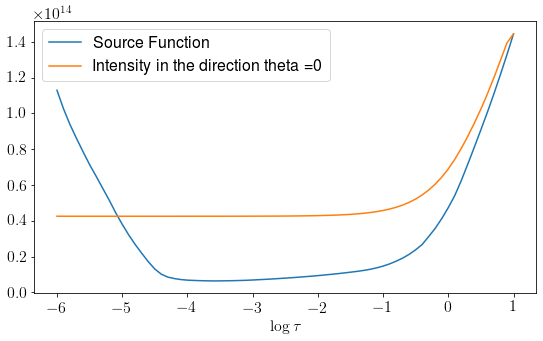

In [80]:
plt.figure(figsize=[9,5])
plt.plot(logtau,S,label='Source Function')
plt.plot(logtau,intensity,label='Intensity in the direction theta =0 ')
plt.legend()
plt.xlabel("$\\log\\tau$")

### Discuss this 3-4 mins. 
Write the conclusions here:

Intensity is not the same as the source function. It is "nonlocal" (ok Ivan, we get it, you said million times!)


### Now how about using a grid of $mu$ angles?

### We are solving 
### $$\mu \frac{dI}{d\tau} = I-S $$

### $$\frac{dI}{d\tau / \mu} = I-S $$

### $\mu$ goes from 0 to 1 



In [81]:
NM = 10
ND = len(S)


# create mu grid
mu = np.linspace(0.1,1.0,NM)

intensity_grid = np.zeros([NM,ND])

# Calculate the intensity in each direction:
for m in range(0,10):
    intensity_grid[m] = synthesis_whole(S,tau/mu[m])

Text(0.5, 0, '$\\mu = \\cos\\theta$')

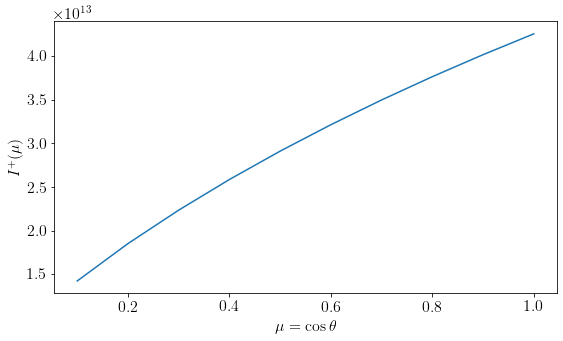

In [82]:
plt.figure(figsize=[9,5])
plt.plot(mu,intensity_grid[:,0])
plt.ylabel("$I^+(\mu)$")
plt.xlabel("$\mu = \cos\\theta$")

### Limb darkening!

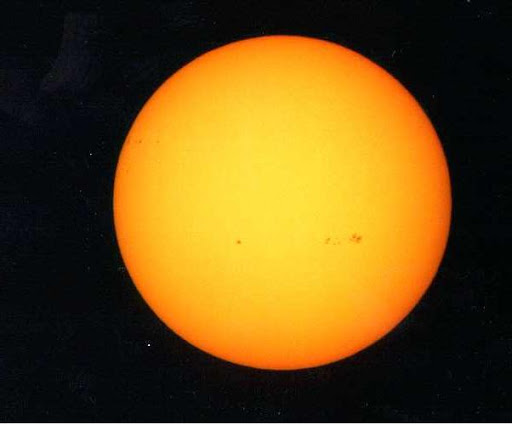

### Limb darkening explanation:

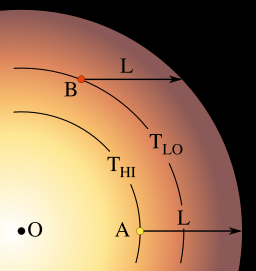

# Now the scattering problem! 

### Solve, iteratively:

### $$S = \epsilon B + (1-\epsilon) J $$
### $$ J = \frac{1}{4\pi} \int_0^{\pi} \int_0^{2\pi} I(\theta,\phi) \sin \theta d\theta d\phi =   \frac{1}{2} \int_{-1}^{1} I(\mu) d\mu $$

### How to calculate J at the top of the atmosphere from the intensity we just calculated?

Would you all agree that, at the top:

$$J = \frac{1}{2} \int_{-1}^{1} I(\mu) d\mu = \frac{1}{2} \int_{0}^{1} I(\mu) d\mu =  \frac{1}{2}\sum_m (I_m + I_{m+1}) \frac{\mu_{m+1}-\mu_{m}}{2}$$

In [83]:
# simplified trapezoidal rule:
# Starting value:
J = 0.
for m in range(0,NM-1):
    J += (intensity_grid[m,0] + intensity_grid[m+1,0]) * (mu[m+1] - mu[m])/2.0
J *= 0.5

In [84]:
print ("ratio of the mean intensity at the surface to the Planck function at the surface is: ", J/B[0])

ratio of the mean intensity at the surface to the Planck function at the surface is:  0.11910542541966643


### Now the next step would be, to say: 

### $$S = \epsilon B + \epsilon J $$

There are, however, few hurdles before that: 

- We don't know $\epsilon$. Let's assume there is a lot of scattering and set $\epsilon=10^{-2}$
- We don't know J everywhere, we only calculate at the top. This one is harder to fix. 

To really calculate J everywhere properly we need to solve radiative transfer equation going inward. 

### Convince yourself that that is really what we have to do. 

How do we solve the RTE inward? Identically to upward except we start from the top and go down. Let's sketch a scheme for that. 

In [85]:
# Old RTE solver looks like this. Renamed it to out so that we know it is the outgoing intensity

def synthesis_out(S,tau):
    
    ND = len(S)
    intensity = np.zeros(ND)
    
    # At the bottom, intensity is equal to the source function (similar to Blackbody)
    intensity[ND-1] = S[ND-1]
    
    for d in range(ND-2,-1,-1):
        # optical thickness of the layer:
        delta_tau = tau[d+1] - tau[d]
        # Mean source function:
        S_mean = (S[d+1] + S[d])*0.5
        
        intensity[d] = intensity[d+1] * np.exp(-delta_tau) + S_mean *(1.-np.exp(-delta_tau))
    
    return intensity

def synthesis_in(S,tau):
    
    ND = len(S)
    intensity = np.zeros(ND)
    
    # At the top, intensity is equal to ZERO
    intensity[0] = 0.0
    
    # The main difference now is that this "previous" or "upwind" point is the point before (d-1)
    
    for d in range(1,ND,1):
        # optical thickness of the layer:
        delta_tau = tau[d] - tau[d-1] # Note that I am using previous point now
        # Mean source function:
        S_mean = (S[d] + S[d-1])*0.5
        
        intensity[d] = intensity[d-1] * np.exp(-delta_tau) + S_mean *(1.-np.exp(-delta_tau))
    
    return intensity


In [87]:
# Now we can solve and we will have two different intensities, in and out one 

int_out = np.zeros([NM,ND])
int_in  = np.zeros([NM,ND])

# We solve in multiple directions:
for m in range(0,10):
    int_out[m] = synthesis_out(S,tau/mu[m])
    int_in[m]  = synthesis_in (S,tau/mu[m])

Text(0.5, 1.0, 'Intensity distribution at the top of the atmosphere')

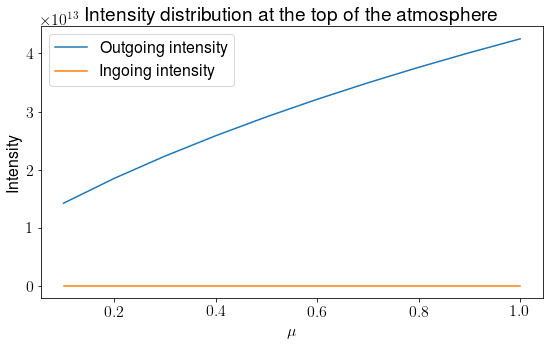

In [96]:
# It is interesting now to visualize the outgoing intensity, and, 
# for example, the intensity at the bottom. How about that:

plt.figure(figsize=[9,5])
plt.plot(mu,int_out[:,0],label='Outgoing intensity')
plt.plot(mu,int_in[:,0], label='Ingoing intensity')
plt.legend()
plt.xlabel("$\\mu$")
plt.ylabel("Intensity")
plt.title("Intensity distribution at the top of the atmosphere")

Text(0.5, 1.0, 'Intensity distribution at the bottom of the atmosphere')

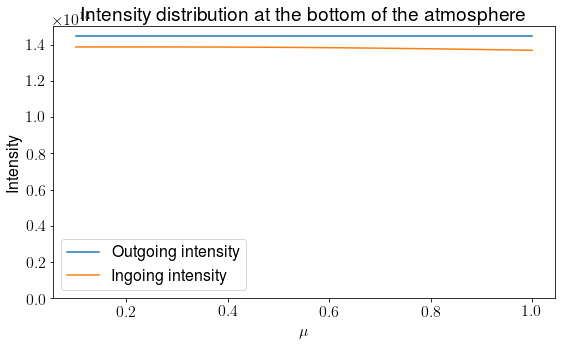

In [98]:
# Here is the bottom intensity
# Don't be confused by the expression outgoing / ingoing. We mean "at that point"

plt.figure(figsize=[9,5])
plt.plot(mu,int_out[:,ND-1],label='Outgoing intensity')
plt.plot(mu,int_in[:,ND-1], label='Ingoing intensity')
plt.legend()
plt.xlabel("$\\mu$")
plt.ylabel("Intensity")
plt.ylim([0,1.5E14])
plt.title("Intensity distribution at the bottom of the atmosphere")

### Take a moment here and try to think about these two things: 

- The intensity at the bottom is much more close to each other and much less strongly depends on $\mu$. Would you call that situation "isotropic"?
- Why is this so?